<a href="https://colab.research.google.com/github/xu-pu/colab-notebooks/blob/master/sympy_double_pendulum_eom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Derive the equation of motion of a double pendulum

In [2]:
from sympy import *
init_printing()

Declare symbols

In [3]:
t, g, l1, l2, m1, m2, ddq1, ddq2 = symbols('t g l_1 l_2 m_1 m_2 \ddot{q_1} \ddot{q_2}')
q1 = Function('q_1')(t)
q2 = Function('q_2')(t)
dq1 = Function('\dot{q_1}')(t)
dq2 = Function('\dot{q_2}')(t)
t, g, l1, l2, m1, m2, q1, q2, dq1, dq2, ddq1, ddq2

Derive the positions and velocities of the centers of mass

In [4]:
x1 = l1 * cos(q1)
y1 = -l1 * sin(q1)
x2 = x1 + l2 * cos(q1+q2)
y2 = y1 - l2 * sin(q1+q2)

# substitution rules
rule = [(q1.diff(t),dq1),(q2.diff(t),dq2), (dq1.diff(t),ddq1), (dq2.diff(t),ddq2)]

dx1 = x1.diff(t).subs(rule)
dy1 = y1.diff(t).subs(rule)
dx2 = x2.diff(t).subs(rule)
dy2 = y2.diff(t).subs(rule)

Derive the Lagrangian $\mathcal{L} = T-V$

In [5]:
T1 = 0.5 * m1 * (dx1**2 + dy1**2)
T2 = 0.5 * m2 * (dx2**2 + dy2**2)

V1 = m1 * g * y1
V2 = m2 * g * y2

T = T1+T2
V = V1+V2

L = T-V

Construct the Euler-Lagrange Equation
$$
\frac{d}{d t} \frac{\partial \mathcal{L}}{\partial \dot{q}}-\frac{\partial \mathcal{L}}{\partial q} = 0
$$

In [6]:
eq1 = L.diff(dq1).diff(t) - L.diff(q1)
eq1 = eq1.subs(rule)
eq1 = simplify(eq1)


eq2 = L.diff(dq2).diff(t) - L.diff(q2)
eq2 = eq2.subs(rule)
eq2 = simplify(eq2)

Solve for $\ddot{q}$

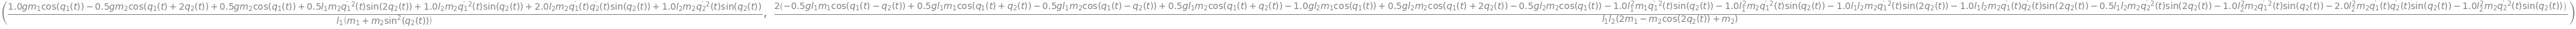

In [7]:
ans = solve((Eq(eq1,0),Eq(eq2,0)),(ddq1, ddq2))
sol_ddq1 = simplify(ans[ddq1])
sol_ddq2 = simplify(ans[ddq2])
sol_ddq1, sol_ddq2

Construct the Equations of Motion (EoM) $\ddot{q} = f(q,\dot{q})$